# 傾向スコアを用いた TV CM の視聴によるゲーム利用傾向の変化の分析

In [68]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [69]:
%load_ext autoreload
%autoreload 2

from pycalf import metrics
from pycalf import visualize
from pycalf import propensity
from pycalf.uplift import UpliftModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Download from https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv
df = pd.read_csv("sample/q_data_x.csv")

In [71]:
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


傾向スコアを求めるために、共変量・結果変数・介入変数を定義します。

In [72]:
# Define variables required for inference.
covariate_cols = [
    "TVwatch_day",
    "age",
    "sex",
    "marry_dummy",
    "child_dummy",
    "inc",
    "pmoney",
    "area_kanto",
    "area_tokai",
    "area_keihanshin",
    "job_dummy1",
    "job_dummy2",
    "job_dummy3",
    "job_dummy4",
    "job_dummy5",
    "job_dummy6",
    "job_dummy7",
    "fam_str_dummy1",
    "fam_str_dummy2",
    "fam_str_dummy3",
    "fam_str_dummy4",
]
outcome_cols = ["gamecount", "gamedummy", "gamesecond"]
treatment_col = "cm_dummy"

傾向スコアを求めるモデルにはロジスティック回帰を用いるので、共変量をスケーリングします。

そして、IPWを用いたモデルを定義します。

In [73]:
# Set Values from dataframe.
X = df[covariate_cols]
y = df[outcome_cols]
treatment = df[treatment_col].astype(bool).to_numpy()

# Scaling Raw Data.
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Convert scaled_X back to a DataFrame with the same column names as X.
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

# Define IPW Class.
learner = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
model = propensity.IPW(learner)

# Fit model.
model.fit(scaled_X, treatment)

## IPW

### 効果量dを用いた共変量の調整の様子を確認

IPW によって、共変量のばらつきが調整されたのかを効果量dを用いて確認する。

In [74]:
ate_weight = model.get_weight(treatment, mode="ate")
es = metrics.EffectSize()
es.fit(X, treatment, weight=ate_weight)
es.transform()

{'effect_name': array(['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc',
        'pmoney', 'area_kanto', 'area_tokai', 'area_keihanshin',
        'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4',
        'job_dummy5', 'job_dummy6', 'job_dummy7', 'fam_str_dummy1',
        'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'], dtype=object),
 'effect_size': array([0.1392268 , 0.07030831, 0.04593512, 0.02837371, 0.01205409,
        0.07131008, 0.00577518, 0.02655479, 0.14569284, 0.01516465,
        0.08086966, 0.03170147, 0.00242427, 0.00904468, 0.05772902,
        0.0064479 , 0.05319938, 0.06225158, 0.01270954, 0.06374104,
        0.00220246])}

<string>:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


<Axes: title={'center': 'Standard Diff'}, ylabel='d value'>

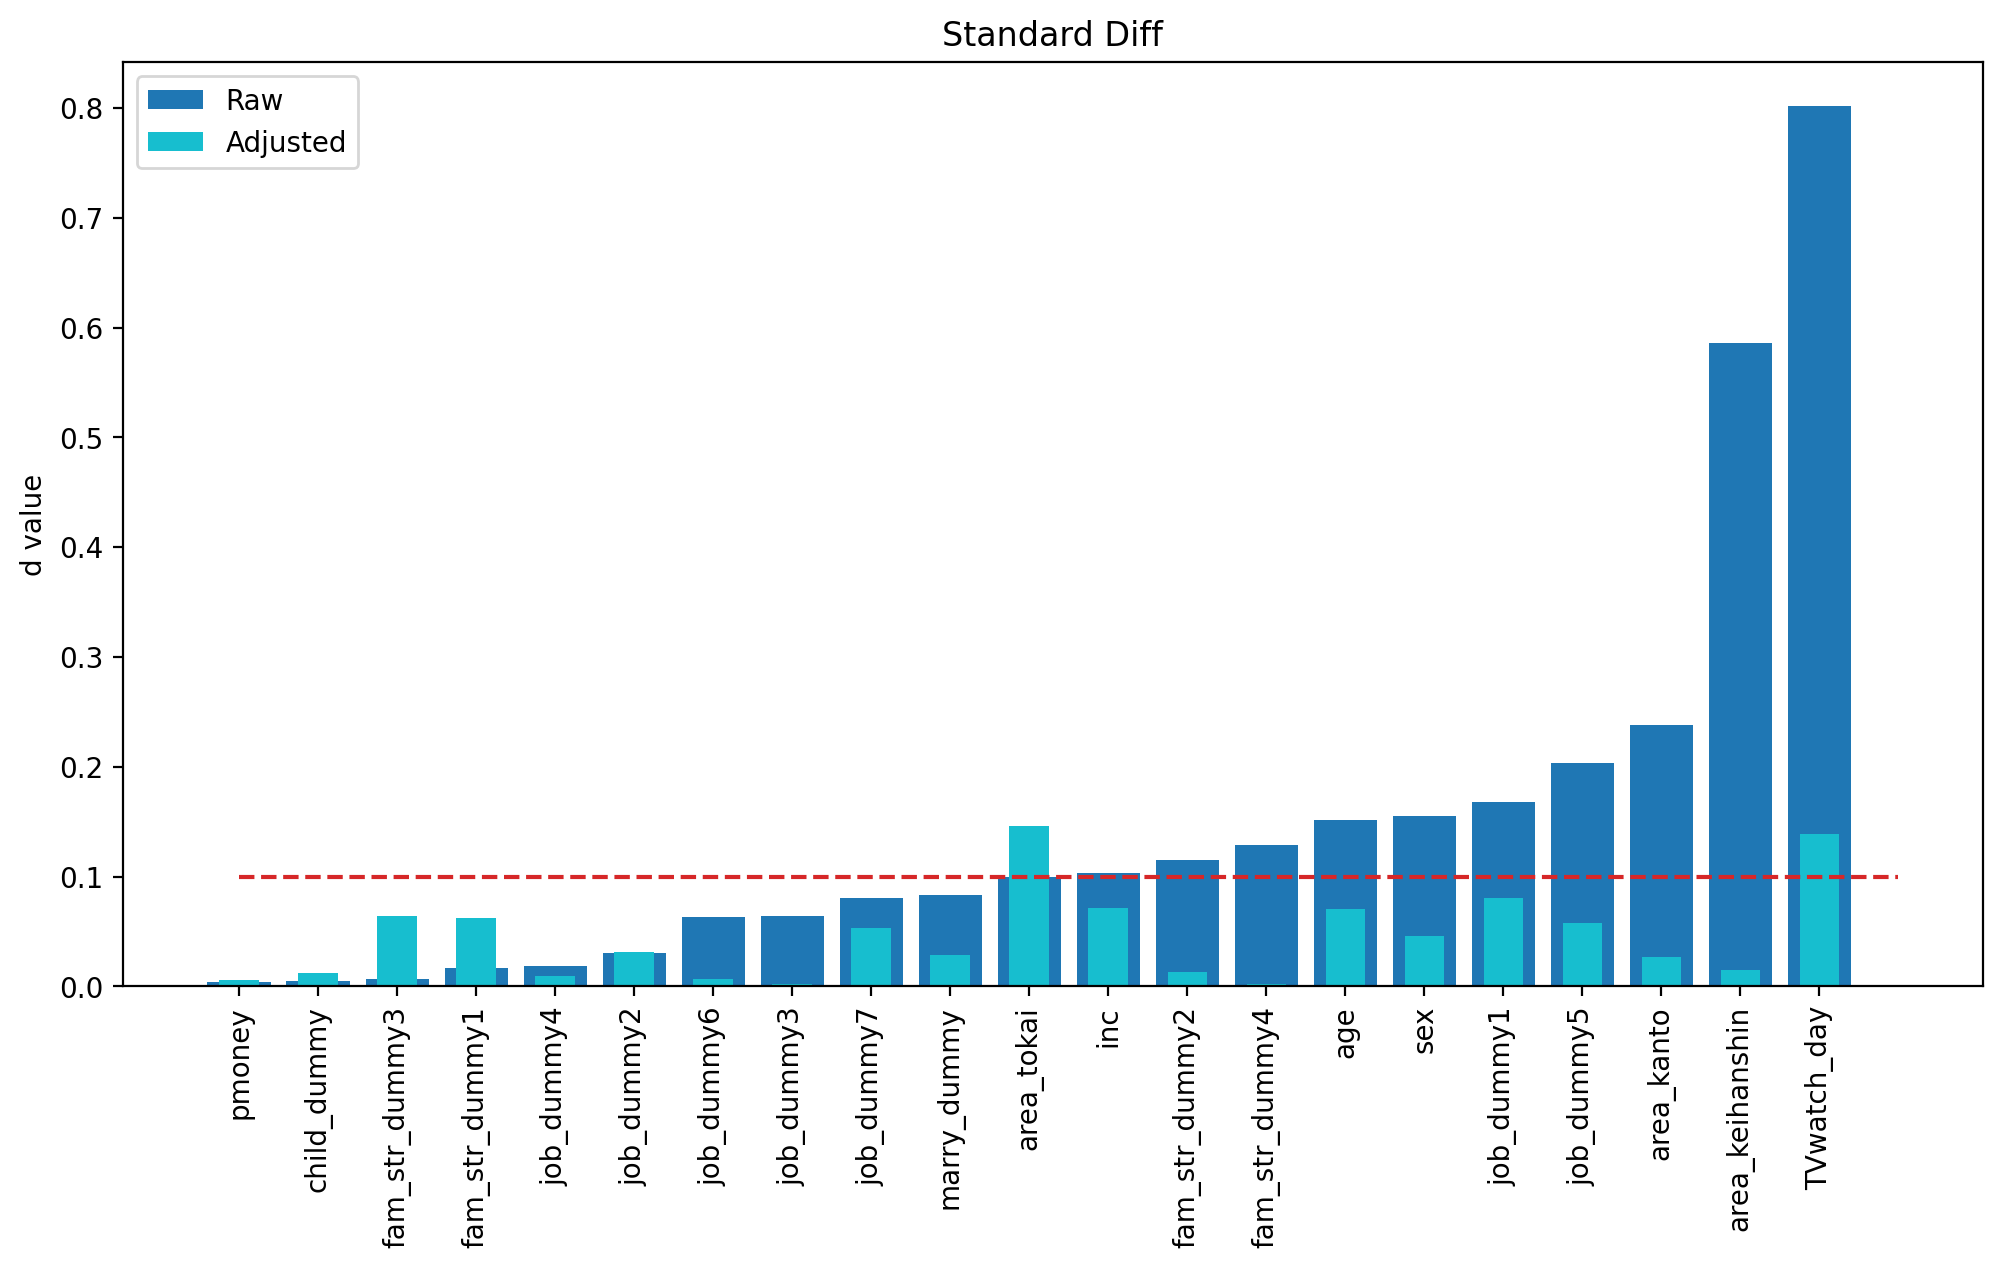

In [75]:
visualize.plot_effect_size(X, treatment, weight=ate_weight, ascending=True)

In [76]:
outcome = model.estimate_effect(treatment, y.to_numpy(), mode="ate")
pd.DataFrame(outcome, index=["Z0", "Z1", "ATE"], columns=y.columns.tolist()).T

,Z0,Z1,ATE
gamecount,8.482789,13.041085,4.558296
gamedummy,0.063531,0.092869,0.029338
gamesecond,2690.247748,3929.405661,1239.157912


<Axes: title={'center': 'gamesecond'}, ylabel='effect size'>

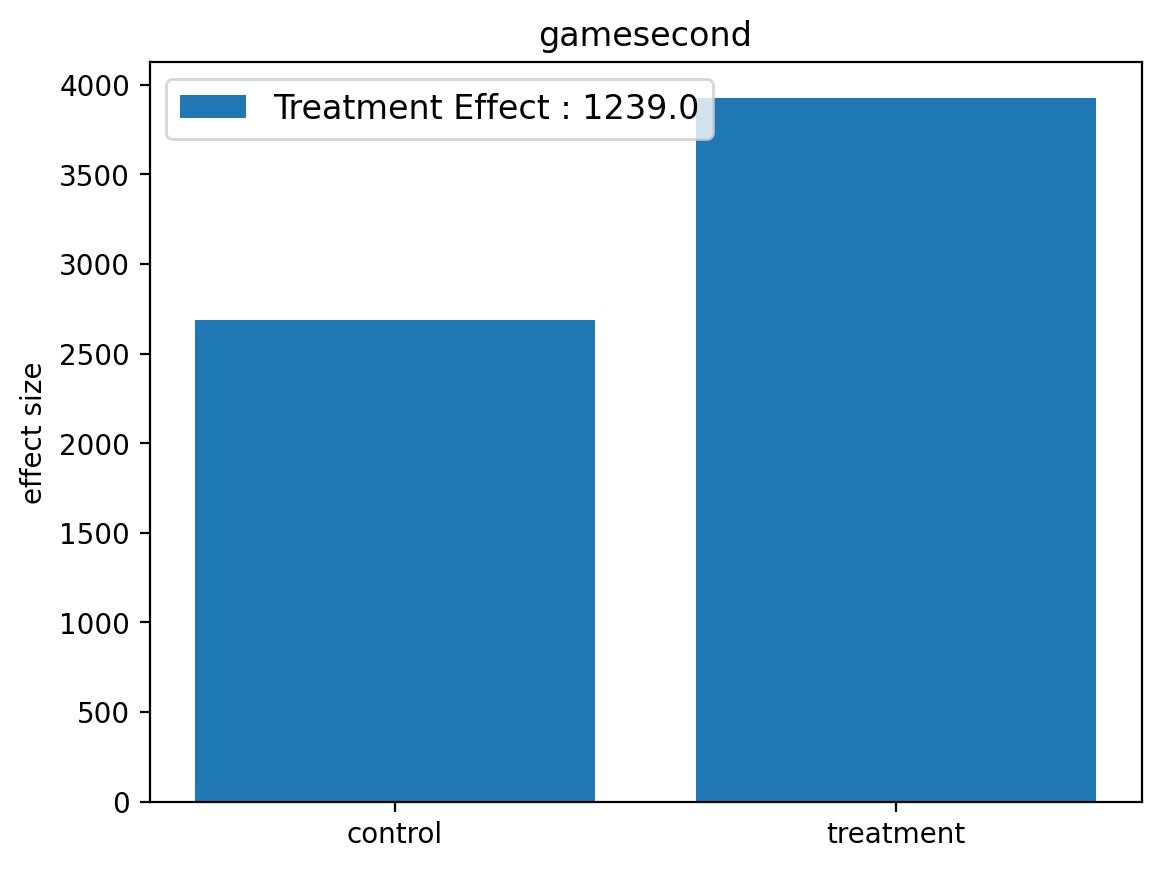

In [77]:
outcome_name = "gamesecond"
z0, z1, treat_effect = model.estimate_effect(
    treatment, y[outcome_name].to_numpy(), mode="ate"
)
visualize.plot_treatment_effect(outcome_name, z0, z1, treat_effect.round())

## Uplift Modeling

In [78]:
import copy
from sklearn.model_selection import train_test_split

In [79]:
# Define variables required for inference.
covariate_cols = [
    "TVwatch_day",
    "age",
    "sex",
    "marry_dummy",
    "child_dummy",
    "inc",
    "pmoney",
    "area_kanto",
    "area_tokai",
    "area_keihanshin",
    "job_dummy1",
    "job_dummy2",
    "job_dummy3",
    "job_dummy4",
    "job_dummy5",
    "job_dummy6",
    "job_dummy7",
    "fam_str_dummy1",
    "fam_str_dummy2",
    "fam_str_dummy3",
    "fam_str_dummy4",
]
outcome_cols = "gamedummy"
treatment_col = "cm_dummy"

# Set Values from dataframe.
scaler = preprocessing.MinMaxScaler()
df[covariate_cols] = scaler.fit_transform(df[covariate_cols].to_numpy())

X = df[covariate_cols]
treatment = df[treatment_col].astype(bool)
y = df[outcome_cols].astype(bool)
weight = model.get_weight(treatment.to_numpy(), mode="ate")


X_train, X_test, z_train, z_test, y_train, y_test, weight_train, weight_test = (
    train_test_split(X, treatment, y, weight, test_size=0.5, random_state=42)
)

In [80]:
X_treat, y_treat = X_train[z_train == 1], y_train[z_train == 1]
X_control, y_control = X_train[z_train == 0], y_train[z_train == 0]
weight_treat, weight_control = weight_train[z_train == 1], weight_train[z_train == 0]


learner = LogisticRegression(solver="lbfgs", C=0.1, max_iter=100, random_state=42)
learner_treat = copy.deepcopy(learner)
learner_control = copy.deepcopy(learner)
model = UpliftModel(learner_treat, learner_control)
model.fit(X_treat, y_treat, X_control, y_control, weight_treat, weight_control)

uplift_score, lift = model.predict(X_test, z_test.to_numpy(), y_test.to_numpy())

/tmp/ipykernel_14312/2163601118.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_qdf = qdf.pivot_table(
/tmp/ipykernel_14312/2163601118.py:13: FutureWarning: The provided callable <function mean at 0x7fc9545331a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_qdf = qdf.pivot_table(


<Axes: xlabel='rank'>

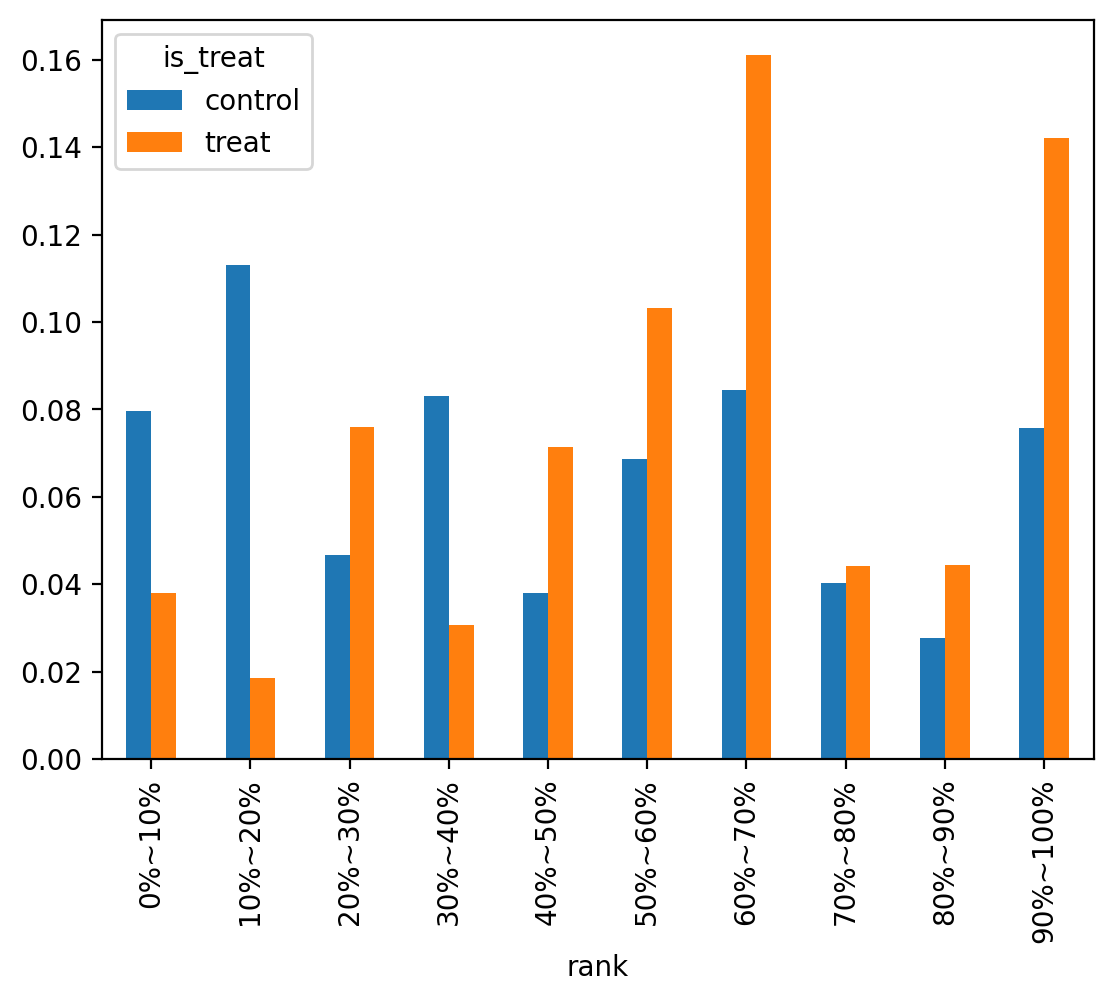

In [81]:
uplift_score = model.estimate_uplift_score(X_test)
result = list(zip(y_test, z_test, uplift_score))
result.sort(key=lambda x: x[2], reverse=True)

qdf = pd.DataFrame(result, columns=("cv", "is_treat", "uplift_sore"))
qdf["rank"] = pd.qcut(
    qdf["uplift_sore"],
    10,
    labels=["{}%~{}%".format(n * 10, (n + 1) * 10) for n in range(10)],
)
qdf["is_treat"] = qdf["is_treat"].map({False: "control", True: "treat"})

pivot_qdf = qdf.pivot_table(
    index="rank", columns="is_treat", values="cv", aggfunc=np.mean
)
pivot_qdf.plot(kind="bar")

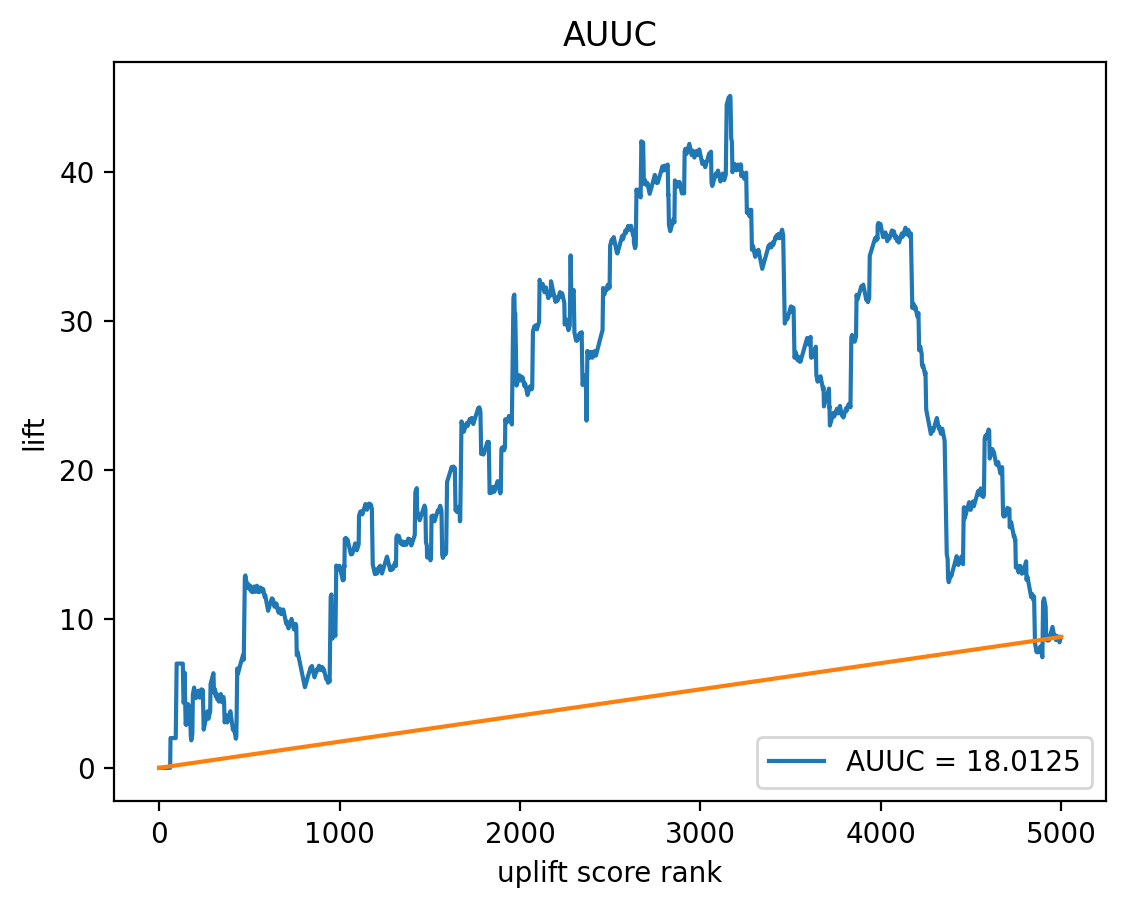

In [85]:
auuc_score = model.get_auuc(lift)
base_line = model.get_baseline(lift)
visualize.plot_auuc(uplift_score, lift, base_line, auuc_score)
plt.show()

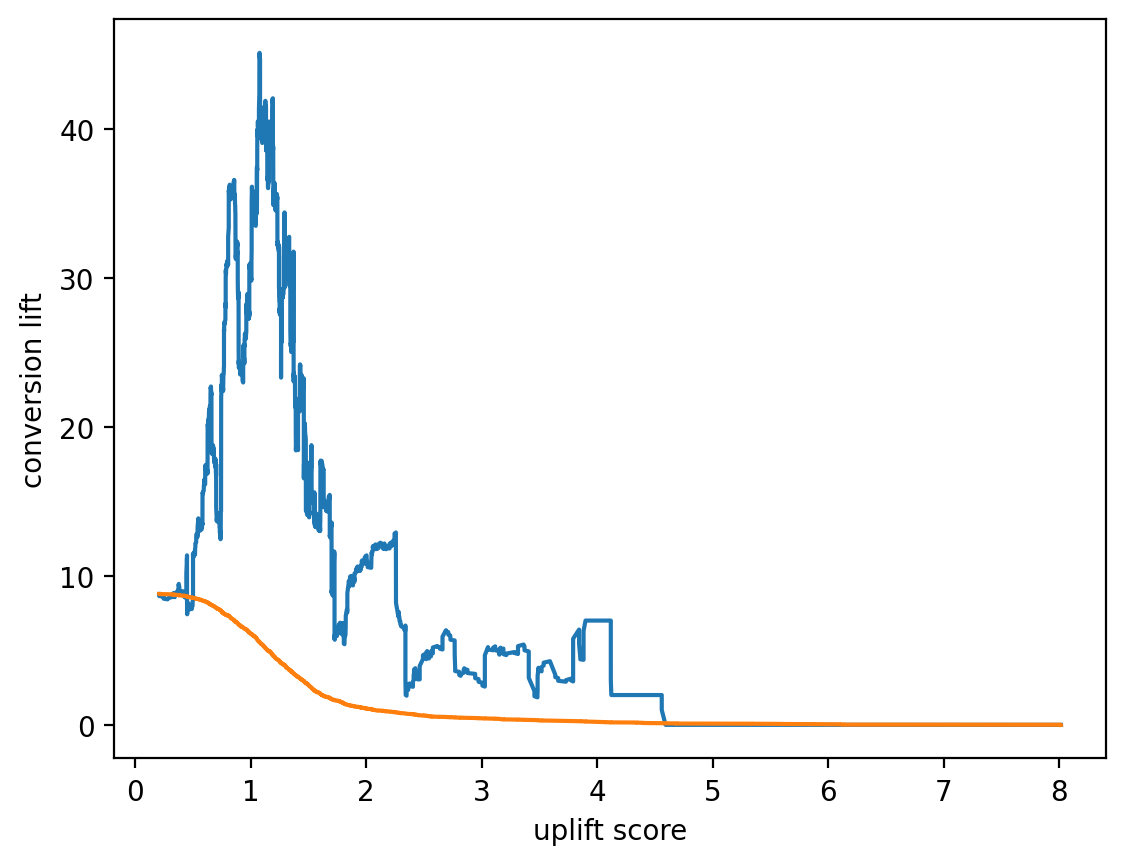

In [84]:
uplift_score, lift = model.predict(X_test, z_test.to_numpy(), y_test.to_numpy())
base_line = model.get_baseline(lift)

plt.plot(uplift_score, lift)
plt.plot(uplift_score, base_line)
plt.xlabel("uplift score")
plt.ylabel("conversion lift")
plt.show()